# Anomaly Detection in TimeSeries - LSTM AutoEncoder

## Importing Libraries

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers as L

plt.style.use('seaborn-v0_8-dark')

## The data

> *"S&P 500,abreviação de Standard & Poor's 500, ou simplesmente S&P, trata-se de um índice composto por quinhentos ativos (ações) cotados nas bolsas de NYSE ou NASDAQ, qualificados devido ao seu tamanho de mercado, sua liquidez e sua representação de grupo industrial. É (S&P 500) um índice ponderado de valor de mercado (valor do ativo multiplicado pelo número de ações em circulação) com o peso de cada ativo no índice proporcional ao seu preço de mercado. S&P faz referência a Standard & Poor's, uma empresa de consultoria financeira."* - [Wikipedia](https://pt.wikipedia.org/wiki/S%26P_500)

In [3]:
df = pd.read_csv('../data/spx.csv', parse_dates=['date'], index_col='date')
display(df.head())
display(df.describe())

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


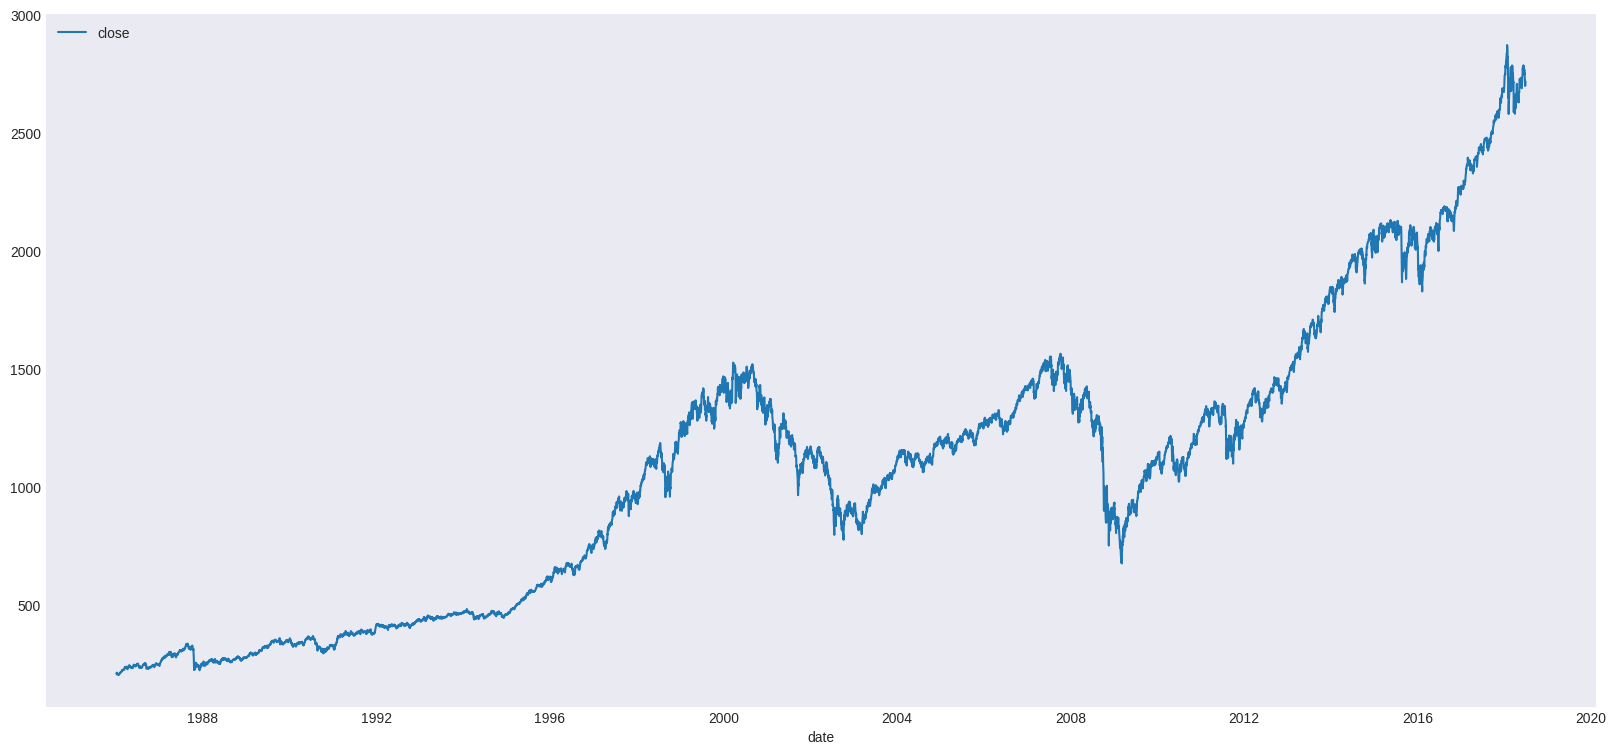

In [4]:
f, ax = plt.subplots(figsize=(20,9))
sns.lineplot(df,ax=ax);

## Preprocessing

In [5]:
train_percent = 0.9
test_percent = 1-train_percent

train_size = int(len(df)*train_percent)
test_size = len(df)-train_size

train, test = df.iloc[0:train_size].copy(), df.iloc[train_size:len(df)].copy()

print(train.shape, test.shape)

(7372, 1) (820, 1)


In [6]:
scaler = StandardScaler()
scaler.fit(train)

StandardScaler()

In [7]:
train['close'] = scaler.transform(train)
test['close'] = scaler.transform(test)

In [26]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [46]:
X_train, y_train = create_dataset(train[['close']], train.close, time_steps=30)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps=30)

In [53]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7342, 30, 1) (7342,)
(790, 30, 1) (790,)


## Model

In [113]:
model = models.Sequential()

model.add(L.LSTM(
    units=64,
    input_shape=(X_train.shape[1],X_train.shape[2])
))

model.add(L.Dropout(0.2))
model.add(L.RepeatVector(n=X_train.shape[1]))
model.add(L.LSTM(units=64, return_sequences=True))
model.add(L.Dropout(0.2))
model.add(L.TimeDistributed(
    L.Dense(units=X_train.shape[2])
))

model.compile(optimizer='adam', loss='mae')

In [114]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                              

In [121]:
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=0
)

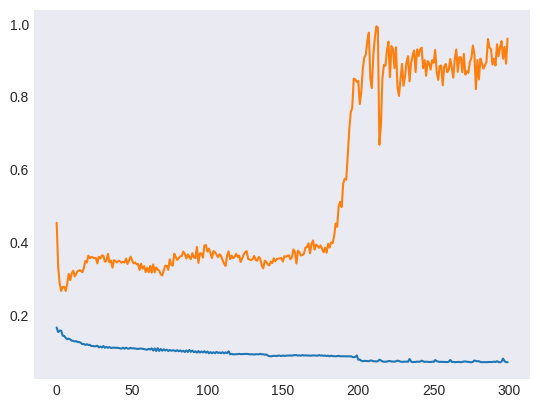

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [123]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

230/230 [==============================] - 1s 5ms/step


230/230 [==============================] - 1s 6ms/step


KeyboardInterrupt: 

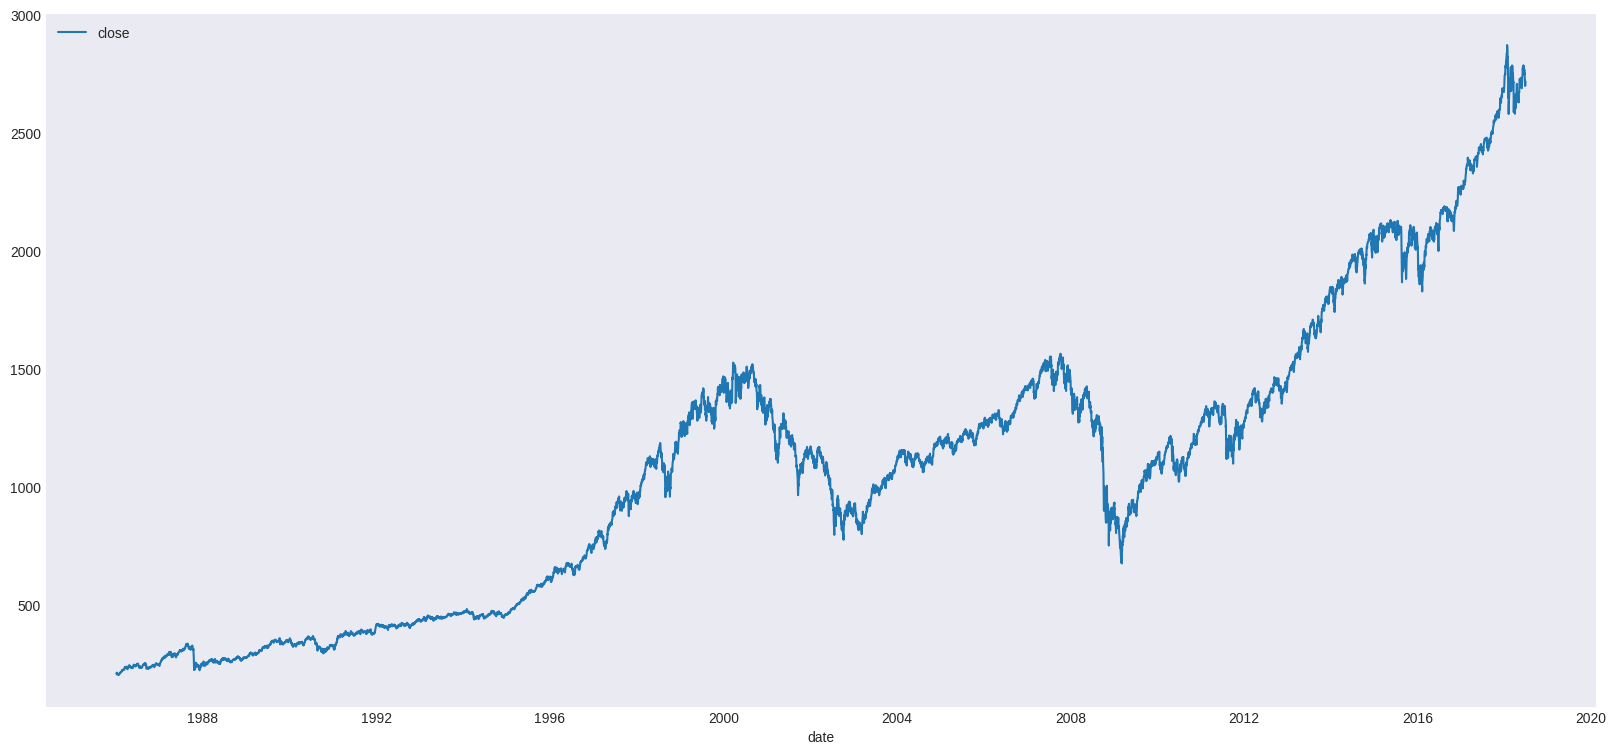

In [128]:
f, ax = plt.subplots(figsize=(20,9))

rec_data = scaler.inverse_transform(model.predict(X_train).reshape(1,-1))

sns.lineplot(df,ax=ax);
sns.lineplot(rec_data);

## Reference

https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/


https://neptune.ai/blog/anomaly-detection-in-time-series